In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset with the correct encoding
df = pd.read_csv('datasets\\Global_terrorist.csv', encoding='ISO-8859-1')
df

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181686,201712310022,2017,12,31,NaN,0,NaN,182,Somalia,11,...,NaN,"""Somalia: Al-Shabaab Militants Attack Army Che...","""Highlights: Somalia Daily Media Highlights 2 ...","""Highlights: Somalia Daily Media Highlights 1 ...",START Primary Collection,0,0,0,0,NaN
181687,201712310029,2017,12,31,NaN,0,NaN,200,Syria,10,...,NaN,"""Putin's 'victory' in Syria has turned into a ...","""Two Russian soldiers killed at Hmeymim base i...","""Two Russian servicemen killed in Syria mortar...",START Primary Collection,-9,-9,1,1,NaN
181688,201712310030,2017,12,31,NaN,0,NaN,160,Philippines,5,...,NaN,"""Maguindanao clashes trap tribe members,"" Phil...",NaN,NaN,START Primary Collection,0,0,0,0,NaN
181689,201712310031,2017,12,31,NaN,0,NaN,92,India,6,...,NaN,"""Trader escapes grenade attack in Imphal,"" Bus...",NaN,NaN,START Primary Collection,-9,-9,0,-9,NaN


<h1>Filtering Data</h1>

In [3]:
filter1 = df[df['region_txt'] == 'Middle East & North Africa'] #50k

In [4]:
filter2 = filter1[filter1['attacktype1_txt'] == 'Bombing/Explosion'] #30k

In [5]:
filter3 = filter2[filter2['nkill'] >= 10]

In [6]:
filter4 = filter3[filter3['iyear'] >= 2000]

<h1>Data Aggregation</h1>

In [7]:
ME_terror = filter4.groupby(['longitude', 'latitude']).size().reset_index(name = 'incident_count')

<h1>Visualization of GeaSpatial using FOLIUM</h1>

<h2>Regional Analysis</h2>

In [8]:
import folium
from folium.plugins import HeatMap

In [9]:
heat_df = ME_terror[['latitude', 'longitude', 'incident_count']].values.tolist()

In [10]:
my_map = folium.Map(location = [30,40], zoom_start = 4)

In [11]:
HeatMap(heat_df).add_to(my_map)

In [12]:
my_map

In [13]:
my_map.save('terrorim_middleeast.html')

In [36]:
df[['nkill','nwound']]  = df[['nkill','nwound']].fillna(0)
df['casualties']        = df['nkill'] + df['nwound']
df[['latitude','longitude']] = df[['latitude','longitude']].apply(pd.to_numeric, errors='coerce')

# Basic global‐filter: post‑2000, has coordinates, ≥1 casualty
base = (df[(df['iyear']>=2000)]
          .dropna(subset=['latitude','longitude'])
          .loc[lambda x: x['casualties']>=1])

<hr>

<h1>Regional Analysis</h1>

In [41]:
regional = (df[df['iyear'] >= 2000].groupby('region_txt').agg(incidents=('iyear','size'),killed   =('nkill','sum'),wounded  =('nwound','sum'),casualties=('casualties','sum'))
      .sort_values('incidents', ascending=False))
regional.head(10)

,incidents,killed,wounded,casualties
region_txt,,,,
Middle East & North Africa,41078,117375.0,186720.0,304095.0
South Asia,37212,74722.0,107389.0,182111.0
Sub-Saharan Africa,13044,56446.0,35187.0,91633.0
Southeast Asia,9562,8197.0,17642.0,25839.0
Eastern Europe,4013,5886.0,9822.0,15708.0
Western Europe,3200,996.0,5892.0,6888.0
South America,2508,3159.0,4830.0,7989.0
North America,648,3502.0,18613.0,22115.0
Central Asia,228,203.0,457.0,660.0


<h3>Top Regions by incidents and casualties since 2000</h3>

<Axes: title={'center': 'Top 5 regions by incidents and casualties since 2000'}, xlabel='region_txt'>

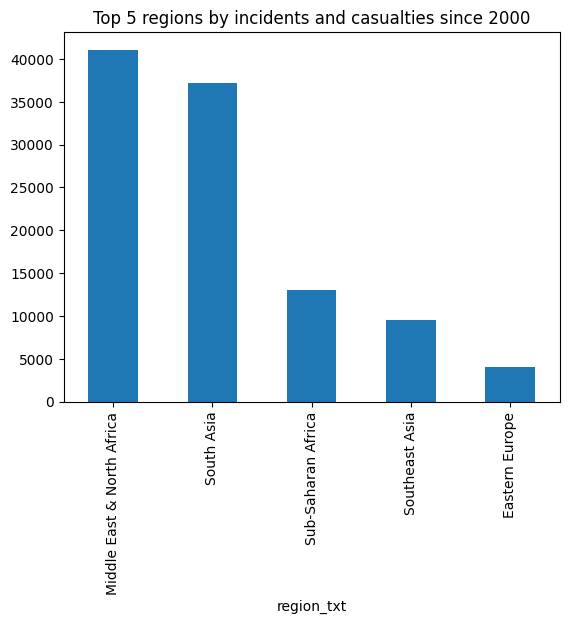

In [69]:
regional['incidents'].head(5).plot.bar(title='Top 5 regions by incidents and casualties since 2000')

In [71]:
for region in ['Middle East & North Africa', 'South Asia',
               'Sub-Saharan Africa', 'Southeast Asia', 'Eastern Europe']:
    sub = base[base['region_txt'] == region]
    pts = sub[['latitude','longitude','casualties']].values.tolist()
    center = [sub['latitude'].median(), sub['longitude'].median()]

    m = folium.Map(center, tiles='CartoDB dark_matter', zoom_start=3)
    HeatMap(pts, radius=12, blur=16, min_opacity=0.3).add_to(m)
    file = f"heat_region_{region.replace(' ','_')}.html"
    m.save(file)
    print(f"✅ saved {file} ({len(sub):,} pts)")


✅ saved heat_region_Middle_East_&_North_Africa.html (30,117 pts)
✅ saved heat_region_South_Asia.html (24,143 pts)
✅ saved heat_region_Sub-Saharan_Africa.html (8,910 pts)
✅ saved heat_region_Southeast_Asia.html (5,884 pts)
✅ saved heat_region_Eastern_Europe.html (2,044 pts)


In [72]:
m

<hr>

<h2>Crime/Attack Analysis</h2>

In [26]:
attack = (
    df.groupby('attacktype1_txt')
      .agg(incidents   =('iyear','size'),
           killed      =('nkill','sum'),
           wounded     =('nwound','sum'))
      .assign(avg_killed_per_incident=lambda x: (x['killed'] / x['incidents']).round(2))
      .sort_values('incidents', ascending=False))
attack.head(10)


,incidents,killed,wounded,avg_killed_per_incident
attacktype1_txt,,,,
Bombing/Explosion,88255,157321.0,372686.0,1.78
Armed Assault,42669,160297.0,77366.0,3.76
Assassination,19312,24920.0,13887.0,1.29
Hostage Taking (Kidnapping),11158,24231.0,6446.0,2.17
Facility/Infrastructure Attack,10356,3642.0,3765.0,0.35
Unknown,7276,32381.0,14725.0,4.45
Unarmed Assault,1015,880.0,14027.0,0.87
Hostage Taking (Barricade Incident),991,4478.0,3966.0,4.52
Hijacking,659,3718.0,17001.0,5.64


<h3>How common vs. how deadly each attack style is</h3>

<Axes: title={'center': 'Top 5 Attack Types by Incidents'}, xlabel='attacktype1_txt'>

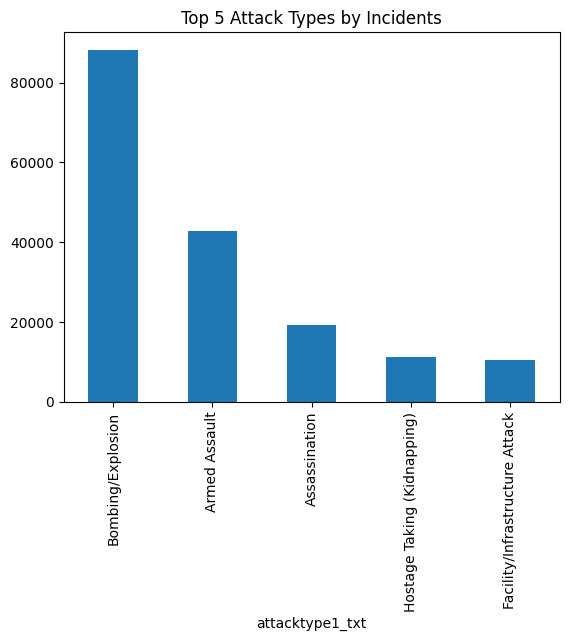

In [30]:
attack['incidents'].head(5).plot.bar(title='Top 5 Attack Types by Incidents')

In [55]:
for atk in ['Bombing/Explosion', 'Armed Assault',
            'Assassination', 'Hostage Taking (Kidnapping)']:

    sub = base[base['attacktype1_txt'] == atk]

    #create the empty base map
    m_attack = folium.Map(
        location=[sub['latitude'].median(), sub['longitude'].median()],
        tiles='CartoDB dark_matter',
        zoom_start=3
    )

    #add the heat layer onto that map
    HeatMap(
        data=sub[['latitude', 'longitude', 'casualties']].values.tolist(),
        radius=13,
        blur=18,
        min_opacity=0.3
    ).add_to(m_attack)

    # display m_attack inline
    file_name = f"heat_attack_{atk.replace('/', '_')}.html"
    m_attack.save(file_name)
    print(f"✅ saved {file_name}  ({len(sub):,} points)")


✅ saved heat_attack_Bombing_Explosion.html  (37,006 points)
✅ saved heat_attack_Armed Assault.html  (22,589 points)
✅ saved heat_attack_Assassination.html  (5,918 points)
✅ saved heat_attack_Hostage Taking (Kidnapping).html  (3,357 points)


In [56]:
m_attack

<hr>

<h1>Causality Analysis</h1>

In [29]:
causal = (
    df.groupby('targtype1_txt')
      .agg(incidents   =('iyear','size'),
           killed      =('nkill','sum'),
           wounded     =('nwound','sum'))
      .assign(avg_killed_per_incident=lambda x: (x['killed'] / x['incidents']).round(2))
      .sort_values('killed', ascending=False))
causal.head(10)

,incidents,killed,wounded,avg_killed_per_incident
targtype1_txt,,,,
Private Citizens & Property,43511,140504.0,178672.0,3.23
Military,27984,106047.0,71038.0,3.79
Police,24506,53704.0,64703.0,2.19
Government (General),21283,26071.0,41184.0,1.22
Business,20669,23487.0,54531.0,1.14
Transportation,6799,13916.0,40679.0,2.05
Religious Figures/Institutions,4440,13413.0,24477.0,3.02
Terrorists/Non-State Militia,3039,9088.0,8223.0,2.99
Unknown,5898,4329.0,3559.0,0.73


<h3>Which targets suffer the most—totals and severity</h3>

<Axes: title={'center': 'Top 5 average killed per incident'}, xlabel='targtype1_txt'>

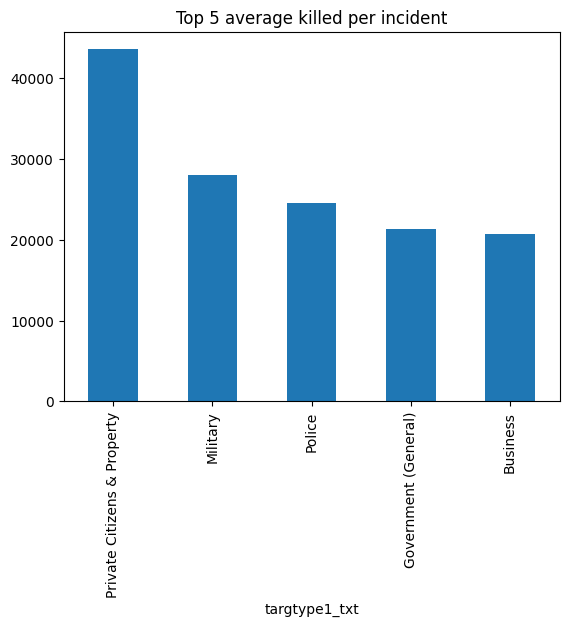

In [66]:
causal['incidents'].head(5).plot.bar(title='Top 5 average killed per incident')

In [67]:
targets = ['Private Citizens & Property', 'Police',
           'Military', 'Government (General)','Business']

for tgt in targets:
    sub = base[base['targtype1_txt'] == tgt]

    # make an empty map first
    m_target = folium.Map(
        location=[sub['latitude'].median(), sub['longitude'].median()],
        tiles='CartoDB dark_matter',
        zoom_start=3
    )

    # add heat layer
    HeatMap(
        data=sub[['latitude', 'longitude', 'casualties']].values.tolist(),
        radius=14,
        blur=20,
        min_opacity=0.3
    ).add_to(m_target)

    # save—or just display m_target inline
    fname = f"heat_target_{tgt.split()[0]}.html"
    m_target.save(fname)
    print(f"✅ saved {fname}  ({len(sub):,} points)")


✅ saved heat_target_Private.html  (22,779 points)
✅ saved heat_target_Police.html  (13,311 points)
✅ saved heat_target_Military.html  (13,850 points)
✅ saved heat_target_Government.html  (7,774 points)
✅ saved heat_target_Business.html  (4,898 points)


In [68]:
m_target

<bl>

<hr>


<H1>Nationality Analysis</H1>

In [31]:
nationality = (
    df.dropna(subset=['country_txt'])
      .groupby('country_txt')
      .agg(incidents=('iyear','size'),
           killed   =('nkill','sum'),
           wounded  =('nwound','sum'))
      .sort_values('incidents', ascending=False))
nationality.head(15)

,incidents,killed,wounded
country_txt,,,
Iraq,24636,78589.0,134690.0
Pakistan,14368,23822.0,42038.0
Afghanistan,12731,39384.0,44277.0
India,11960,19341.0,28980.0
Colombia,8306,14698.0,10328.0
Philippines,6908,9559.0,13367.0
Peru,6096,12771.0,4078.0
El Salvador,5320,12053.0,5062.0
United Kingdom,5235,3410.0,6106.0


<Axes: title={'center': 'Top 5 since 2010'}, xlabel='country_txt'>

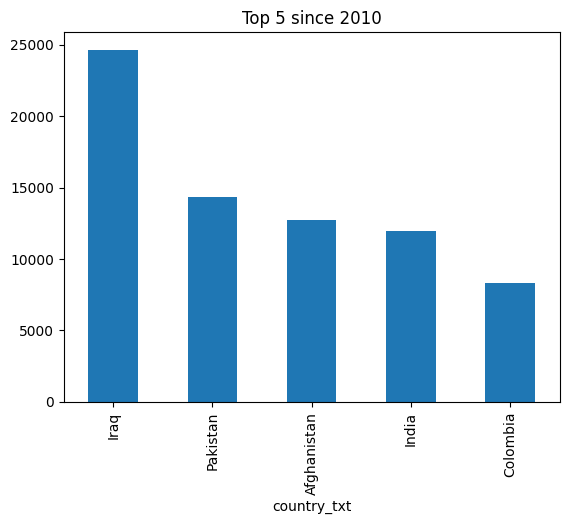

In [60]:
nationality['incidents'].head(5).plot.bar(title='Top 5 since 2010')

In [62]:
countries = ['Iraq', 'Pakistan', 'Afghanistan', 'India', 'Colombia']  # note spelling

for c in countries:
    sub = base[base['country_txt'] == c]

    #  create the base map
    ctry_map = folium.Map(
        location=[sub['latitude'].median(), sub['longitude'].median()],
        tiles='CartoDB dark_matter',
        zoom_start=4
    )

    # add the heat layer
    HeatMap(
        data=sub[['latitude', 'longitude', 'casualties']].values.tolist(),
        radius=12,
        blur=16,
        min_opacity=0.3
    ).add_to(ctry_map)

    # save (or display ctry_map inline)
    file_name = f"heat_perp_{c}.html"
    ctry_map.save(file_name)
    print(f"✅ saved {file_name}  ({len(sub):,} points)")


✅ saved heat_perp_Iraq.html  (20,101 points)
✅ saved heat_perp_Pakistan.html  (7,497 points)
✅ saved heat_perp_Afghanistan.html  (10,119 points)
✅ saved heat_perp_India.html  (4,792 points)
✅ saved heat_perp_Colombia.html  (1,037 points)


In [64]:
ctry_map